In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dataset, dataset_info = tfds.load('malaria',with_info=True, as_supervised=True,shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteMVTBNC/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
def splits(dataset, TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset,val_dataset,test_dataset


In [ ]:
TRAIN_RATIO = 0.25
VAL_RATIO = 0.05
TEST_RATIO = 0.05

# dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))





[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

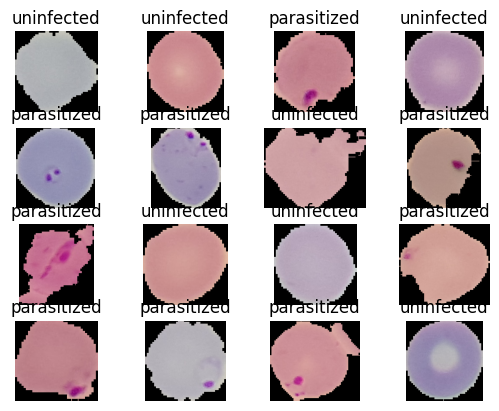

In [ ]:
for i, (image,label) in enumerate(train_dataset.take(16)):
  ax=plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
IM_SIZE = 224
def resize_rescale(image,label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0,label

In [ ]:
train_dataset = train_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)

In [ ]:
for image,label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
lenet_model = tf.keras.Sequential([
                            InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),

                            Conv2D(filters = 6, kernel_size = 3, strides=1, padding = 'valid',activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size = 2, strides  = 2),

                            Conv2D(filters = 16, kernel_size = 3, strides=1, padding = 'valid',activation='relu'),
                             BatchNormalization(),
                            MaxPool2D(pool_size = 2, strides  = 2),

                            Flatten(),

                            Dense(100,activation='relu'),
                            BatchNormalization(),
                            Dense(10,activation='relu'),
                            BatchNormalization(),
                            Dense(1,activation='sigmoid'),
])
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [ ]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 1]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true,y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9340706>

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = 'accuracy')

In [ ]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs = 50, verbose =1)

Epoch 1/50
216/216 [==============================] - 280s 1s/step - loss: 0.1488 - accuracy: 0.9460 - val_loss: 0.6012 - val_accuracy: 0.6071
Epoch 2/50
216/216 [==============================] - 263s 1s/step - loss: 0.1543 - accuracy: 0.9443 - val_loss: 0.5501 - val_accuracy: 0.8802
Epoch 3/50
216/216 [==============================] - 261s 1s/step - loss: 0.1463 - accuracy: 0.9490 - val_loss: 2.1370 - val_accuracy: 0.5011
Epoch 4/50
216/216 [==============================] - 262s 1s/step - loss: 0.1062 - accuracy: 0.9634 - val_loss: 0.5703 - val_accuracy: 0.7654
Epoch 5/50
216/216 [==============================] - 265s 1s/step - loss: 0.2424 - accuracy: 0.9119 - val_loss: 0.3698 - val_accuracy: 0.8664
Epoch 6/50
216/216 [==============================] - 263s 1s/step - loss: 0.3436 - accuracy: 0.8624 - val_loss: 0.7450 - val_accuracy: 0.6768
Epoch 7/50
216/216 [==============================] - 263s 1s/step - loss: 0.2453 - accuracy: 0.9123 - val_loss: 1.8712 - val_accuracy: 0.5018

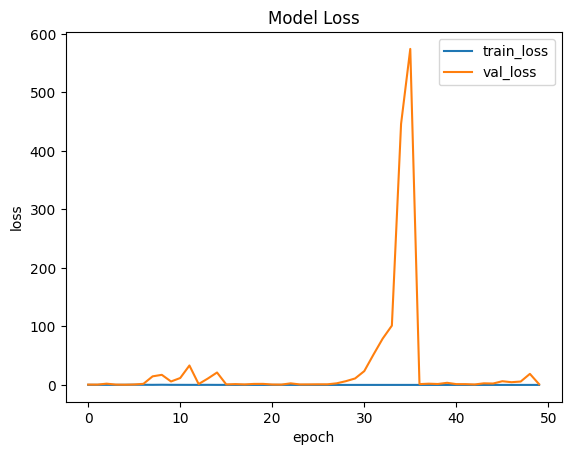

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()


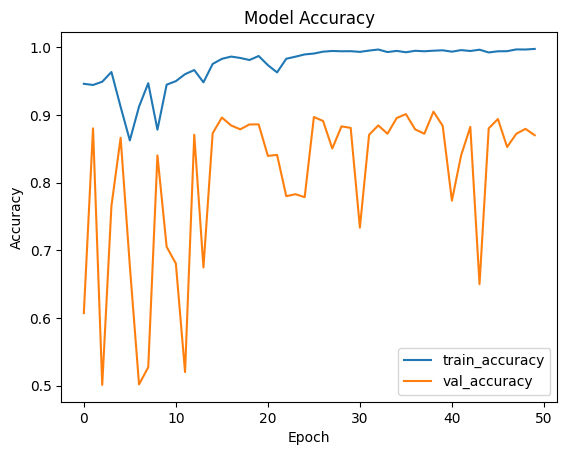

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
lenet_model.evaluate(test_dataset)

19292/19292 [==============================] - 356s 18ms/step - loss: 1.9992 - accuracy: 0.8783


[1.9992222785949707, 0.8783433437347412]

In [ ]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 6s 6s/step


'P'

1/1 [==============================] - 0s 31ms/step


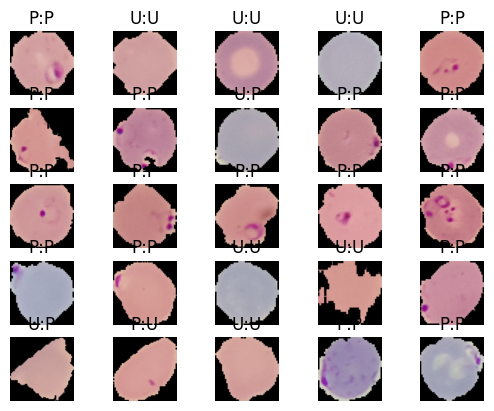

In [ ]:
for i, (image,label) in enumerate(test_dataset.take(25)):
  ax = plt.subplot(5,5,i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))
  plt.axis('off')

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
lenet_model.save('/content/drive/MyDrive/lenet_model_saved.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test_dataset


<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
for image,label in test_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]], shape=(1, 224, 224, 3), dtype=float32) tf.Tensor([0], shape=(1,), dtype=int64)
